In [1]:
!pip install scikit-learn==1.5.0
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 101.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.0 which is incompatible.


In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as T
import torch.utils.data as data_utils
from torch.utils.data import TensorDataset, random_split, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import optuna
import optuna.visualization as vis
import cupy as cp
from cuml.manifold import UMAP as cumlUMAP

crear device para pytorch

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Descargar el dataset 

In [4]:
data_set = np.load('/kaggle/input/kdm-database-spiners/data.npy.npz')
print(data_set.files)

['Nest', 'L', 'rd', 'So', 'T', 'Jex', 'Jex2', 'Jex3', 'Jex4', 'Kan1', 'KanS', 'Hex', 'kd', 'KDM', 'MS']


En "data" se cargan las imagenes de las configuraciones de los espines, se reorganiza para que quede de la forma (N, C, H, W). Se redimensiona de 39x39 a 40x40 para que el cambio de dimensionalidad sea simetrico en el encoder y el decoder

In [5]:
data = data_set['MS']
data.shape
data = torch.from_numpy(data).permute(0, 3, 1, 2).float()
data = F.interpolate(data, size=(40, 40), mode='bilinear')
data = data / data.max() #normalizar, queda [-1,1]
data = (data + 1) / 2 #mover rango [0,1]
data.shape

torch.Size([164212, 1, 40, 40])

Como este es un cvae, "y" va a ser el vector con los parámetros que van a condicionar el modelo

In [6]:
kdm = data_set['KDM']
t = data_set['T']
y = np.column_stack((kdm, t))
y = torch.from_numpy(y).float()
y.shape

torch.Size([164212, 2])

In [7]:
full_dataset = TensorDataset(data, y)

val_size = int(len(full_dataset) * 0.2)
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [8]:
train_loader = data_utils.DataLoader(
    train_dataset, 
    batch_size=128, 
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=128, 
    shuffle=False
)

#### La arquitectura de este CVAE cuenta:
Este es la primera versión del CVAE (concatenación + prior condicionado). 
En este modelo, el VAE se condicionó de la siguiente manera:
- Se pasaron los parámetros (kdm y t) por redes densas y se concatenaron a la salida flatten del encoder, resultando en una distribución $q(x|y)$
- Se condicionó el prior, es decir, se pasó de $p(z)$ a $p(z|y)$
  
Donde $y$ es el vector que contiene a los parámetros kdm y t.

Así, de la distribución marginal aproximada por el encoder $q(x|y)$ resulta $\mu_q$ y $\log{\sigma_q}$

Y de la distribución prior $p(z|y)$ resulta $\mu_p$ y $\log{\sigma_p}$

Para el encoder: se deja la función build_encoder para que durante la optimización pruebe diferentes configuraciones de capas, un flaten despues del ciclo para aplanar los datos y una densa para hallar $\mu$ y $\sigma$

Para el dencoder: una densa para aumentar la dimension de z, una unflatten para pasar de un vector a un tensor y en base al ciclo propuesto en el encoder se establece el número de capas convtranspose que requiere el decoder

Además, se define una función infer_star_dim para calcular el tamaño que tiene el tensor al final del encoder. Lo que se hace es pasar un tensor de ceros con el mismo tamaño de la imagen original a través del encoder, así, se guarda las dimensiones de la ultima capa conv para cuando se necesite hacer unflatten

In [9]:
class CVAE(nn.Module):
    def __init__(self, z_dim, layers_config, device, cond_dim=2):
        super(CVAE, self).__init__()
        self.z_dim = z_dim
        self.layers_config = layers_config
        self.kernel_size = 4
        self.stride = 2
        self.padding = 1
        self.cond_dim = cond_dim
        # mover todo a gpu
        self.device = device  

        self.cond = nn.Sequential(
            nn.Linear(self.cond_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2)
        ).to(self.device)
        
        self.cond_dim_process = 128

        self.encoder = self._build_encoder(layers_config).to(self.device)
        self.flat_dim, self.h_start, self.w_start = self._infer_start_dim()
        
        self.fc_mu_q = nn.Linear(self.flat_dim + self.cond_dim_process, z_dim).to(self.device)
        self.fc_logvar_q = nn.Linear(self.flat_dim + self.cond_dim_process, z_dim).to(self.device)
        self.decoder = self._build_decoder().to(self.device)

        # condicionamiento en el prior
        self.fc_mu_p = nn.Linear(self.cond_dim_process, z_dim).to(self.device)
        self.fc_logvar_p = nn.Linear(self.cond_dim_process, z_dim).to(self.device)
        
    # crea el encoder en base a las configuraciones
    def _build_encoder(self, layers_config):
        layers = []
        in_ch = 1
        for (n_filters, use_bn) in layers_config:
            layers.append(nn.Conv2d(in_ch, n_filters, kernel_size=3, stride=2, padding=1))
            if use_bn:
                layers.append(nn.BatchNorm2d(n_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            in_ch = n_filters
        layers.append(nn.Flatten())
        encoder = nn.Sequential(*layers)
        return encoder

    # se guardan dimensiones de la ultima capa
    def _infer_start_dim(self):
        # tensor de ceros con el tamaño de la imagen para pasarlo por el encoder
        x = torch.zeros(1, 1, 40, 40).to(self.device)
        
        with torch.no_grad():
            # encoder temporal sin flatten para medir dimensiones espaciales
            temp_encoder = nn.Sequential(*list(self.encoder.children())[:-1]) 
            temp_encoder.eval()            
            current_layer = x

            
            for layer in temp_encoder:
                current_layer = layer(current_layer)

            out = current_layer
        
        flat_dim = out.shape[1] * out.shape[2] * out.shape[3]
        h_start, w_start = out.shape[2], out.shape[3] 
        
        return flat_dim, h_start, w_start

    # crea el decoder también en base a las configuraciones de capas
    def _build_decoder(self):
        layers = []
        layers.append(nn.Linear(self.z_dim + self.cond_dim_process, self.flat_dim))
        # se pasa deun vector plano a un tensor con las dimensiones de la ultima capa convolucional del encoder
        layers.append(nn.Unflatten(1, (self.layers_config[-1][0], self.h_start, self.w_start)))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        # se invierte el vector de las configuraciones
        reversed_config = list(reversed(self.layers_config))
        
        N_layers = len(reversed_config) # Total de capas transpuestas necesarias
        
        # la primera entrada (input chanel) es la última del encoder
        in_ch = reversed_config[0][0] 
        for i in range(N_layers): 
            
            # atualización de los canales
            is_final_layer = (i == N_layers - 1)
            
            # si no es la capa final, el out_ch es el filtro de la siguiente capa en la config inversa
            out_ch = 1 if is_final_layer else reversed_config[i+1][0] 
            
            # la configuración de BN se toma de la capa a la que se está transponiendo (el out_ch)
            use_bn = reversed_config[i+1][1] if not is_final_layer else False
            
            # se construyen las capas conv
            layers.append(nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1))
            in_ch = out_ch
            
            # Aplicar BN y LeakyReLU, excepto en la capa de salida final
            if not is_final_layer:
                if use_bn:
                    layers.append(nn.BatchNorm2d(out_ch))
                layers.append(nn.LeakyReLU(0.2, inplace=True))
            else:
                layers.append(nn.Sigmoid())
                
        decoder = nn.Sequential(*layers)
        return decoder
    
    def encode(self, x, y):
        h = self.encoder(x)
        y_process = self.cond(y)
        #concatenacion
        combined = torch.cat([h, y_process], dim=1)
        mu_q = self.fc_mu_q(combined)
        logvar_q = self.fc_logvar_q(combined)
        return mu_q, logvar_q

    # Calcula el prior condicionado
    def get_prior(self, y):
        y_process = self.cond(y)
        mu_p = self.fc_mu_p(y_process)
        logvar_p = self.fc_logvar_p(y_process)
        return mu_p, logvar_p

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std
        return z

    def decode(self, z, y):
        y_process = self.cond(y)
        combined = torch.cat([z, y_process], dim=1)
        return self.decoder(combined)

    def forward(self, x, y):
        mu_q, logvar_q = self.encode(x, y)
        z = self.reparameterize(mu_q, logvar_q)
        x_hat = self.decode(z, y)
        mu_p, logvar_p = self.get_prior(y)
        return x_hat, mu_q, logvar_q, mu_p, logvar_p

    def get_intermediate_features(self, x):
        features = {}
        h = x
        conv_blocks = list(self.encoder.children())
        
        # Layer 1
        h = conv_blocks[0](h)
        # Aplanar de (B, C, H, W) a (B, C*H*W)
        features['L1'] = h.flatten(start_dim=1) 
        
        # Layer 2
        h = conv_blocks[1](h)
        features['L2'] = h.flatten(start_dim=1)
    
        # Layer 3
        h = conv_blocks[2](h)
        features['L3'] = h.flatten(start_dim=1)
        
        return features

La función de pérdida está dada por: 


$$
L_{\text{loss}} = \frac{1}{N} \sum_{k=1}^{N} \left[ L_{\text{MSE}}(x_k, \hat{x}_k) + \beta \cdot D _{KL}(q_k || p) \right]
$$
$$
L_{loss} = \frac{1}{N} \sum_{k=1}^{N} \left( \frac{1}{D} \sum_{i=1}^{D} \left( x_{k,i} - \hat{x}_{k,i} \right) ^2 \right)  +  \beta \cdot \sum _{k=1}^{N} \left( \sum _{j=1}^{Z}{(-0.5(1 + \log (\sigma^2 _{k,j}) - \mu^2 _{k,j} - \sigma ^2 _{k,j})}) \right) 
$$
Donde, $$N= \text{tamaño del batch, } D= \text{numero de pixeles (1 * 40 * 40), } Z = \text{dimension de z, } \beta = \text{peso de la KLD}$$

In [10]:
def loss_function(x_hat, x, mu_q, logvar_q, mu_p, logvar_p, beta):
    MSE = F.mse_loss(x_hat, x, reduction='sum')
    var_q = torch.exp(logvar_q)
    var_p = torch.exp(logvar_p)
    
    KLD = 0.5 * torch.sum(logvar_p - logvar_q + (var_q + (mu_q - mu_p).pow(2)) / var_p - 1)
    loss = (MSE + beta * KLD) / x.size(0)
    return loss, MSE, KLD

A diferencia del anterior cuadernillo, se va aplicar bayes optimización (con la librería optuna) para encontrar los mejores hiperparametros para esta red. En este caso se quiere optimizar:
- lr: learning rate
- z_dim: dimensión del espacio latente
- beta: importancia que se le da a la kl divergence
- batch_size: tamaño del batch sobre el se entrena en cada época
- optimizer: verificar si es mejor con adam o con descenso de gradiente
- growth: escalamiento de los filtros en cada capa
- use_bn: si se usa batch normalization o no después de cada capa

El modelo sustituo utilizado es: TPE (Tree-structured Parzen Estimators)
$$\text{TPE}_{Acq}(x) \propto \frac{l(x)}{g(x)}$$
Donde, 
- $l(x) = p(x | y < y^*)$ : La densidad de probabilidad de los hiperparámetros $x$ que dieron buenos resultados (una pérdida $y$ por debajo de un umbral $y^*$)
- $g(x) = p(x | y \ge y^*)$ : La densidad de probabilidad de los hiperparámetros $x$ que dieron malos resultados

Y la función de adquisición es: EI (Expected Improvement)
$$EI(x) = \sigma(x) [Z \Phi(Z) + \phi(Z)]$$
Donde, 
- $y^*$ es el mejor valor (mínimo) de la función objetivo (pérdida) observado hasta ahora.
- $\mu(x)$ y $\sigma(x)$ son la media y la desviación estándar predichas por el modelo sustituto en el punto $x$
- $Z = \frac{y^* - \mu(x)}{\sigma(x)}$
- $\phi(Z)$ es la Función de Densidad de Probabilidad (PDF) de una distribución normal estándar
- $\Phi(Z)$ es la Función de Distribución Acumulada (CDF) de una distribución normal estándar

In [11]:
def objective(trial):
    params = {
        'lr': trial.suggest_float('lr', 1e-5, 5e-2, log=True), 
        'z_dim': trial.suggest_int('z_dim', 8, 64),
        'beta': trial.suggest_float('beta', 0.1, 10.0, log=True), 
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256, 512]),
        'base_filters': trial.suggest_categorical('base_filters', [16, 32, 64, 128]),
        'growth': trial.suggest_float("growth", 1.0, 2.0),
        'use_bn': trial.suggest_categorical("use_bn", [True, False])
    }
    
    # crear vector con las configuraciones de las capas
    layers_config = []
    for i in range(3):
        filters = int(params['base_filters'] * (params['growth'] ** i))
        layers_config.append((filters, params['use_bn']))
    
    # actualizar el train loader con las nuevas configuraciones
    train_loader = DataLoader(
        train_dataset, 
        batch_size=params['batch_size'], 
        shuffle=True
    )
    
    model = CVAE(z_dim=params['z_dim'], layers_config=layers_config, device=device, cond_dim=2)
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    num_epochs = 30
    
    model.train()
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        
        for data, y in train_loader:
            data = data.to(device).float()
            y = y.to(device).float()
            recon, mu_q, logvar_q, mu_p, logvar_p = model(data, y)
            
            loss, _, _ = loss_function(recon, data, mu_q, logvar_q, mu_p, logvar_p, params['beta'])
            
            # Si la pérdida es NaN, es una mala prueba
            if torch.isnan(loss):
                raise optuna.TrialPruned()
            
            optimizer.zero_grad()
            loss.backward()
            
            # recorte de gradiente para que no exploten
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            epoch_loss += loss.item() * data.size(0)
        
        # Pérdida promedio de la época
        avg_epoch_loss = epoch_loss / len(train_dataset)
        
        # Manejar el caso de que la pérdida sea NaN
        if np.isnan(avg_epoch_loss):
            raise optuna.TrialPruned()
        
        # Reportar el valor intermedio y verificar si se debe podar el trial
        trial.report(avg_epoch_loss, epoch)
        
        # Verificar si el trial debe ser podado
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    # Retornar la pérdida final
    return avg_epoch_loss

study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3, interval_steps=1 ))

study.optimize(objective, n_trials=50)

print(f"Mejores parámetros: {study.best_params}")
print(f"Mejor valor: {study.best_value}")
print(f"Trials completados: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
print(f"Trials podados: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")

[I 2025-11-18 17:17:22,077] A new study created in memory with name: no-name-e29407cd-180d-4899-b12b-3a9c798865b4
[I 2025-11-18 17:19:42,340] Trial 0 finished with value: 49.439666285474544 and parameters: {'lr': 1.3168567081424072e-05, 'z_dim': 49, 'beta': 4.331128883184685, 'batch_size': 256, 'base_filters': 16, 'growth': 1.2192068641787674, 'use_bn': True}. Best is trial 0 with value: 49.439666285474544.
[I 2025-11-18 17:23:32,463] Trial 1 finished with value: 26.58778914240857 and parameters: {'lr': 7.471601129351455e-05, 'z_dim': 44, 'beta': 1.1302164446593361, 'batch_size': 512, 'base_filters': 32, 'growth': 1.9541676317607268, 'use_bn': True}. Best is trial 1 with value: 26.58778914240857.
[I 2025-11-18 17:23:32,543] Trial 2 pruned. 
[I 2025-11-18 17:27:00,948] Trial 3 finished with value: 43.496316525881134 and parameters: {'lr': 2.5570340120731256e-05, 'z_dim': 12, 'beta': 6.780635447593822, 'batch_size': 128, 'base_filters': 32, 'growth': 1.189166308307258, 'use_bn': False}. 

Mejores parámetros: {'lr': 0.0011785331104065553, 'z_dim': 64, 'beta': 0.1013322948202451, 'batch_size': 64, 'base_filters': 64, 'growth': 1.476083655965836, 'use_bn': False}
Mejor valor: 14.99669676640811
Trials completados: 22
Trials podados: 28


Se grafica la importancia/sensiblidad de cada hiperparámetro en el modelo

In [12]:
# importancia 
fig = vis.plot_param_importances(study)
fig.show()

In [13]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def step(self, current_loss):
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

El entrenamiento se realiza con los mejores parámetros encontrados por bayes

In [14]:
best_params = study.best_params

num_epochs = 30
z_dim = best_params['z_dim'] 
beta = best_params['beta']
num_layers = 3
base_filters = best_params['base_filters']
growth = best_params['growth']
use_bn = best_params['use_bn']

layers_config = []

for i in range(num_layers):
        filters = int(base_filters * (growth ** i))
        layers_config.append((filters, use_bn))


model = CVAE(z_dim=z_dim, layers_config=layers_config, device=device, cond_dim=2)

optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=best_params['batch_size'] , 
    shuffle=True
)
epoch_loss_history = {'total': [], 'mse': [], 'kld': [], 'val_mse': []}

early_stopper = EarlyStopping(patience=5, min_delta=1e-3)
for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    running_mse = 0.0 # Acumulador para mse
    running_kld = 0.0 # Acumulador para KLD
    
    for batch_idx, (data, y) in enumerate(train_loader):
        data = data.to(device) 
        y = y.to(device)
        # propagacion
        recon_batch, mu_q, logvar_q, mu_p, logvar_p = model(data, y)
        
        # perdida 
        loss, mse_sum, kld_sum = loss_function(recon_batch, data, mu_q, logvar_q, mu_p, logvar_p, beta)
        
        # backpropagation y opt
        optimizer.zero_grad() # Limpia gradientes
        loss.backward()       # Calcula gradientes
        optimizer.step()      # Actualiza pesos

        # Acumula la pérdida
        running_loss += loss.item() * data.size(0) 
        running_mse += mse_sum.item() # Acumular BCE total
        running_kld += kld_sum.item() # Acumular KLD total
    
    # Calcular promedios por época
    avg_loss = running_loss / len(train_dataset)
    avg_mse = running_mse / len(train_dataset)
    avg_kld = running_kld / len(train_dataset)
    
    # Guardar promedios de la época
    epoch_loss_history['total'].append(avg_loss)
    epoch_loss_history['mse'].append(avg_mse)
    epoch_loss_history['kld'].append(avg_kld)

    #validacion
    model.eval()
    running_val_mse = 0.0
    with torch.no_grad():
        for val_data, val_y in val_loader:
            val_data = val_data.to(device)
            val_y = val_y.to(device).float()
            
            # generar imagen desde la condicion y
            mu_p, logvar_p = model.get_prior(val_y)
            z_sample = model.reparameterize(mu_p, logvar_p) 
            recon_batch = model.decode(z_sample, val_y)
            
            val_mse = F.mse_loss(recon_batch, val_data, reduction='sum')
            running_val_mse += val_mse.item()

    avg_val_mse = running_val_mse / len(val_dataset)
    epoch_loss_history['val_mse'].append(avg_val_mse)
    
    if early_stopper.step(avg_loss):
        print(f"Early stopping activado en la época {epoch+1}")
        break

    # Reporte de la época 
    print(f"Epoch [{epoch+1}/{num_epochs}], Pérdida Total: {avg_loss:.4f}, MSE: {avg_mse:.4f}, KLD: {avg_kld:.4f}")

print("finish.")

Epoch [1/30], Pérdida Total: 19.3572, MSE: 16.0279, KLD: 32.8553
Epoch [2/30], Pérdida Total: 16.0335, MSE: 12.7706, KLD: 32.2007
Epoch [3/30], Pérdida Total: 15.7182, MSE: 12.5761, KLD: 31.0083
Epoch [4/30], Pérdida Total: 15.5601, MSE: 12.4883, KLD: 30.3142
Epoch [5/30], Pérdida Total: 15.4545, MSE: 12.4293, KLD: 29.8540
Epoch [6/30], Pérdida Total: 15.3813, MSE: 12.3921, KLD: 29.4993
Epoch [7/30], Pérdida Total: 15.3165, MSE: 12.3580, KLD: 29.1965
Epoch [8/30], Pérdida Total: 15.2640, MSE: 12.3310, KLD: 28.9442
Epoch [9/30], Pérdida Total: 15.2287, MSE: 12.3124, KLD: 28.7798
Epoch [10/30], Pérdida Total: 15.1931, MSE: 12.2914, KLD: 28.6353
Epoch [11/30], Pérdida Total: 15.1681, MSE: 12.2786, KLD: 28.5148
Epoch [12/30], Pérdida Total: 15.1498, MSE: 12.2669, KLD: 28.4507
Epoch [13/30], Pérdida Total: 15.1326, MSE: 12.2563, KLD: 28.3842
Epoch [14/30], Pérdida Total: 15.1142, MSE: 12.2434, KLD: 28.3306
Epoch [15/30], Pérdida Total: 15.0980, MSE: 12.2325, KLD: 28.2787
Epoch [16/30], Pérd

In [15]:
MODEL_PATH = '/kaggle/working/vae_spines_pesos_final.pth'

torch.save(model.state_dict(), MODEL_PATH)

print(f"pesos guardados en: {MODEL_PATH}")

pesos guardados en: /kaggle/working/vae_spines_pesos_final.pth


se grafica la función de pérdida, en este caso se añade la pérdida por validación ya que pasó a ser un modelo condicionado entonces se puede evaluar con una validación

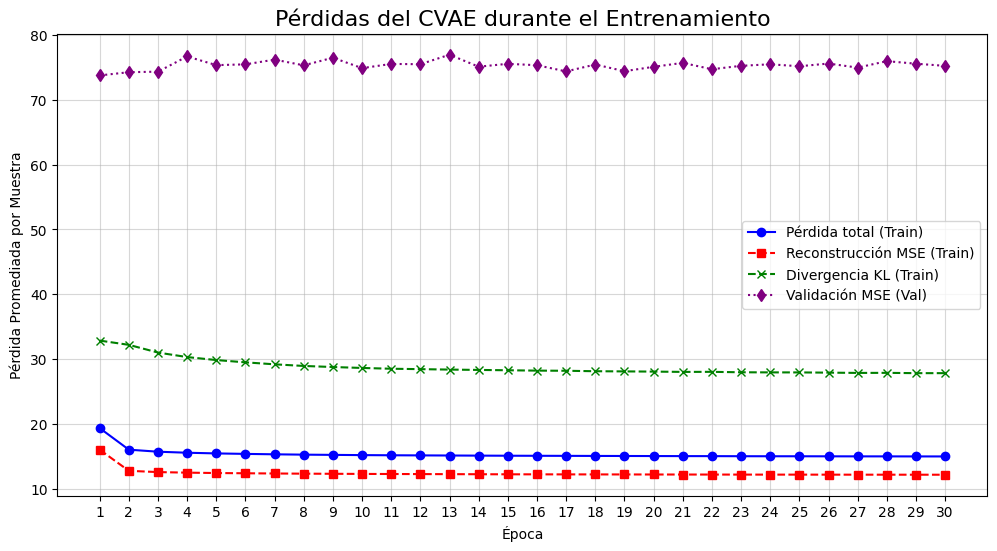

In [16]:
def plot_epoch_loss_history(history):
    plt.figure(figsize=(12, 6))
    
    epochs = range(1, len(history['total']) + 1)
    
    plt.plot(epochs, history['total'], label='Pérdida total (Train)', color='blue', marker='o')
    plt.plot(epochs, history['mse'], label='Reconstrucción MSE (Train)', color='red', linestyle='--', marker='s')
    plt.plot(epochs, history['kld'], label='Divergencia KL (Train)', color='green', linestyle='--', marker='x')
    plt.plot(epochs, history['val_mse'], label='Validación MSE (Val)', color='purple', linestyle=':', marker='d')
    
    # Etiquetas y Título
    plt.title('Pérdidas del CVAE durante el Entrenamiento', fontsize=16)
    plt.xlabel('Época')
    plt.ylabel('Pérdida Promediada por Muestra')
    plt.xticks(epochs) 
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.show()

plot_epoch_loss_history(epoch_loss_history)

Estimar imagenes y compararlas con las originales

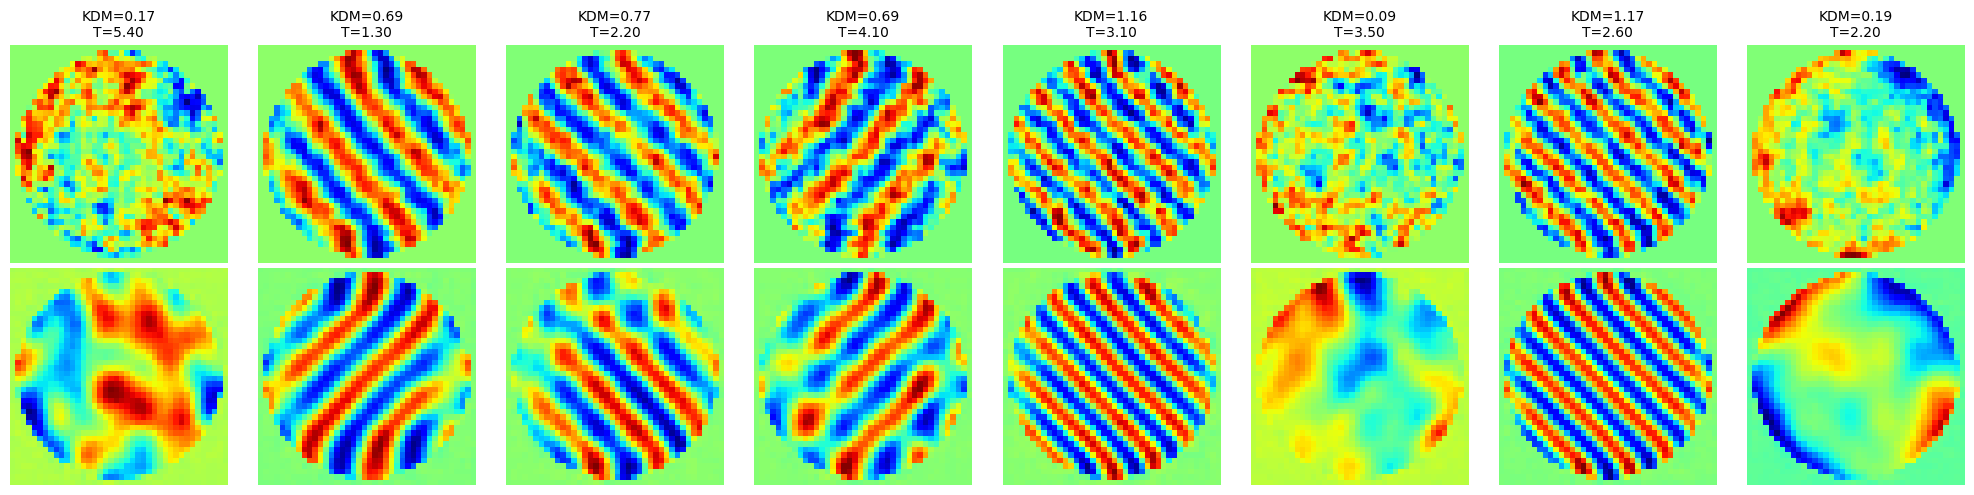

In [17]:
model.eval()

data_val, y_val = next(iter(val_loader))
data_val = data_val.to(device)
y_val = y_val.to(device)

with torch.no_grad():
    _, _, _, mu_p, log_p = model(data_val, y_val)
    z_prior = model.reparameterize(mu_p, log_p)
    gen_val = model.decode(z_prior, y_val)

# Mover a CPU para plotear
data_val = data_val.cpu()
gen_val = gen_val.cpu()

# Número de ejemplos a plotear
n = 8 

plt.figure(figsize=(n * 2.5, 5)) 

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(data_val[i, 0], cmap='jet')
    ax.set_title(f"KDM={y_val[i,0]:.2f}\nT={y_val[i,1]:.2f}", fontsize=10)
    if i == 0:
        ax.set_ylabel("Original", fontsize=12, weight='bold')
    ax.axis('off')
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(gen_val[i, 0], cmap='jet')
    if i == 0:
        ax.set_ylabel("Generada", fontsize=12, weight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

visualización del espacio latente con umap.
se visualiza el espacio latente después de cada capa y en el espacio latente final se superponen las imagenes estimadas 

In [18]:
model.eval()
# Diccionario para almacenar los features aplanados de L1, L2, L3
all_features = {'L1': [], 'L2': [], 'L3': []}
all_z = []
all_T = []
all_KDM = []

with torch.no_grad():
    for data_batch, y_batch in val_loader:
        data_batch = data_batch.to(device)
        y_batch = y_batch.to(device)

        #  Extraer features intermedios
        intermediate_features = model.get_intermediate_features(data_batch)
        for key in all_features:
            all_features[key].append(intermediate_features[key].cpu().numpy())
            
        #  Extraer espacio latente (media mu_q)
        mu_q, _ = model.encode(data_batch, y_batch)
        all_z.append(mu_q.cpu().numpy())

        #  Extraer etiquetas (KDM es índice 0, T es índice 1)
        all_KDM.append(y_batch[:, 0].cpu().numpy()) 
        all_T.append(y_batch[:, 1].cpu().numpy())     

# Concatenar todos los batches
for key in all_features:
    all_features[key] = np.concatenate(all_features[key], axis=0)

all_z = np.concatenate(all_z, axis=0)
all_T = np.concatenate(all_T)
all_KDM = np.concatenate(all_KDM)

# aplicar umap a las capas
umap_results = {}
layers = ['L1', 'L2', 'L3']
all_spaces = layers + ['Z']
for space in all_spaces:
    if space == 'Z':
        data_to_map = all_z
    else:
        data_to_map = all_features[space]

    data_cp = cp.asarray(data_to_map)
    reducer = cumlUMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    umap_coords_cp = reducer.fit_transform(data_cp)
    umap_results[space] = cp.asnumpy(umap_coords_cp)

[2025-11-18 21:26:49.064] [CUML] [info] build_algo set to brute_force_knn because random_state is given
[2025-11-18 21:27:53.584] [CUML] [info] build_algo set to brute_force_knn because random_state is given
[2025-11-18 21:28:56.440] [CUML] [info] build_algo set to brute_force_knn because random_state is given
[2025-11-18 21:29:19.305] [CUML] [info] build_algo set to brute_force_knn because random_state is given


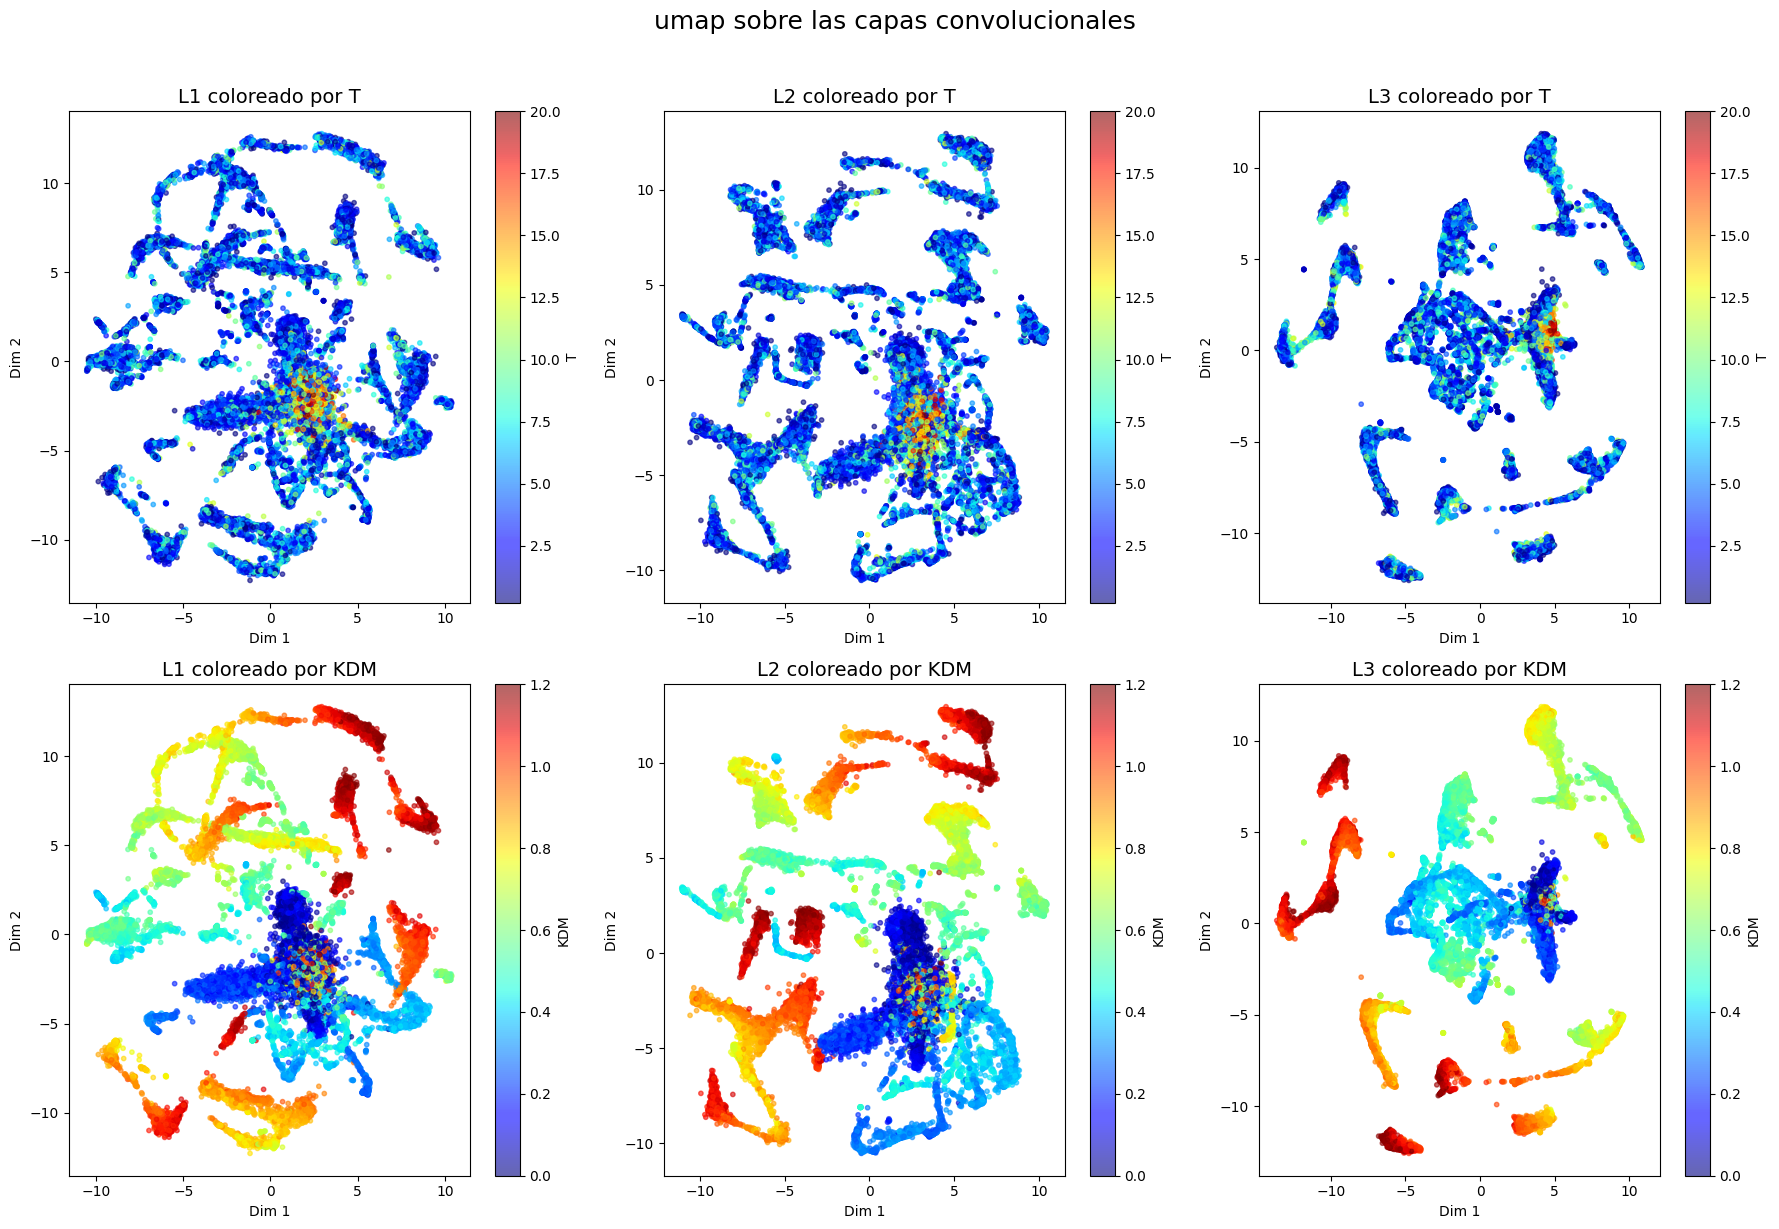

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
layers = ['L1', 'L2', 'L3']
color_data = [all_T, all_KDM]
color_labels = ['T', 'KDM']

for row, (c_data, c_label) in enumerate(zip(color_data, color_labels)):
    
    for col, layer in enumerate(layers):
        ax = axes[row, col]
        coords = umap_results[layer]
        
        scatter = ax.scatter(coords[:, 0], coords[:, 1], c=c_data, cmap='jet', s=10, alpha=0.6)
        
        ax.set_title(f"{layer} coloreado por {c_label}", fontsize=14)
        ax.set_xlabel("Dim 1")
        ax.set_ylabel("Dim 2")
        fig.colorbar(scatter, ax=ax, label=c_label)

plt.suptitle("umap sobre las capas convolucionales", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [20]:
x_test = torch.stack([x for x, y in val_dataset]).to(device)
y_test = torch.stack([y for x, y in val_dataset]).to(device)

model.eval()
with torch.no_grad():
    # se usa el modelo completo para obtener el vector latente (mu_q)  
    # y luego solo se usa el decoder para la estimación a partir de y
    _, mu_q, _, _, _ = model(x_test, y_test)
    x_generated_from_z = model.decode(mu_q, y_test)
    
z_test_np = mu_q.cpu().numpy()
z_test_cp = cp.asarray(z_test_np)

umap_model = cumlUMAP(n_components=2, random_state=42)
embedding_Z = cp.asnumpy(umap_model.fit_transform(z_test_cp))
gen_images_for_umap = x_generated_from_z.cpu().numpy()


[2025-11-18 21:29:27.038] [CUML] [info] build_algo set to brute_force_knn because random_state is given


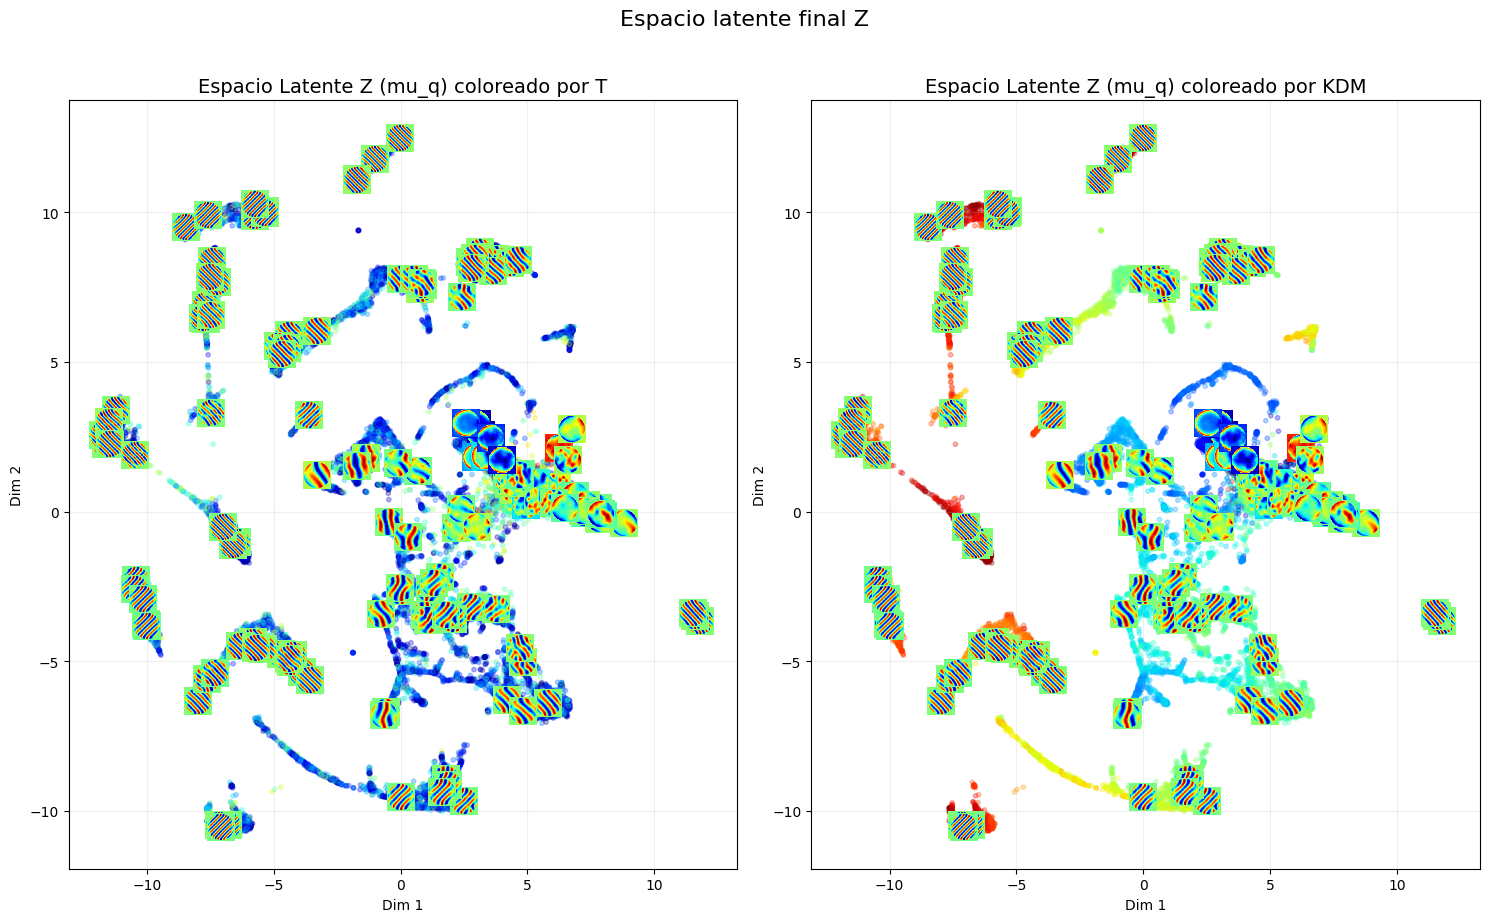

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15, 9))

coords_z = umap_results['Z']
color_data_z = [all_T, all_KDM]

# coloreado por t
ax_T = axes[0]
scatter_T = ax_T.scatter(coords_z[:, 0], coords_z[:, 1], c=color_data[0], cmap='jet', s=10, alpha=0.3) 
ax_T.set_title("Espacio Latente Z (mu_q) coloreado por T", fontsize=14)
ax_T.set_xlabel("Dim 1")
ax_T.set_ylabel("Dim 2")
ax_T.grid(True, alpha=0.2) 

# coloreado por kdm
ax_KDM = axes[1]
scatter_KDM = ax_KDM.scatter(coords_z[:, 0], coords_z[:, 1], c=color_data[1], cmap='jet', s=10, alpha=0.3) # Reducimos alfa
ax_KDM.set_title("Espacio Latente Z (mu_q) coloreado por KDM", fontsize=14)
ax_KDM.set_xlabel("Dim 1")
ax_KDM.set_ylabel("Dim 2")
ax_KDM.grid(True, alpha=0.2) 

# subconjunto de img a superponer
n_images_to_plot = 150 
if n_images_to_plot > len(coords_z):
    n_images_to_plot = len(coords_z)

indices = np.random.choice(range(len(coords_z)), n_images_to_plot, replace=False)

for i in indices:
    img_np = gen_images_for_umap[i].transpose(1, 2, 0)
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    imagebox = OffsetImage(img_np, zoom=0.5, cmap='jet') 
    x_coord = coords_z[i, 0]
    y_coord = coords_z[i, 1]
    ab_T = AnnotationBbox(imagebox, (x_coord, y_coord), frameon=False, pad=0.0)
    ax_T.add_artist(ab_T)
    ab_KDM = AnnotationBbox(imagebox, (x_coord, y_coord), frameon=False, pad=0.0)
    ax_KDM.add_artist(ab_KDM)

plt.suptitle("Espacio latente final Z", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()